In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import defaultdict

# 短语情感分类

对Phrase字段中的文本进行分类，分类结果为

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [2]:
train = pd.read_csv('train.tsv', sep='\t')
train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [3]:
train.sample(20)

,PhraseId,SentenceId,Phrase,Sentiment
49588,49589,2428,simple but absorbing,3
119667,119668,6400,slapping extreme humor,3
60788,60789,3069,insignificant,1
130946,130947,7057,"tortured , dull",1
47009,47010,2291,you think you are making sense of it,2
146972,146973,7999,any sexual relationship,2
97893,97894,5126,"trying simply to out-shock , out-outrage or ou...",0
101433,101434,5334,lost twenty-first century America,2
54795,54796,2728,simple and,2
99126,99127,5199,carries Arnold,2


## 数据预处理
1. 统计单词频率并保留频率最高的1000个单词，构建单词到索引的映射，以及构建索引到单词的映射。

In [4]:
# 使用部分数据
# train = train.head(1000)

# 创建字典
len_list = []
word_freq_map = defaultdict(int)
for sentence in train.Phrase:
    words = sentence.split()
    words = [w.lower() for w in words] # 统一为小写
    len_list.append(len(words))
    for word in words:
        word_freq_map[word] += 1

word_freq_map = dict(sorted(word_freq_map.items(),
                                   key=lambda x: x[1], reverse=True))
top_k_words = 100000
# 使用列表根据序号查找单词 (特殊词 <UNK> 表示未登录词)
idx2word = list(word_freq_map.keys())[:top_k_words] + ['<UNK>', '<PAD>'] # 
# 使用词典根据单词查找序号
word2idx = {idx2word[i]:i for i in range(len(idx2word))}
print('<UNK>:', word2idx['<UNK>'])

<UNK>: 16531


2. 构建基于Bag-of-Words的数据集

In [5]:
# Bag of Words dataset 
def extract_word_index_feat(df, idx2word, word2idx, max_len=40):
    X = []
    for sentence in df.Phrase:
        x = np.ones(max_len,dtype=np.int64)*word2idx['<PAD>'] # 默认全部为填充词<PAD>
        words = sentence.split()
        words = [w.lower() for w in words][:max_len]
        for i,w in enumerate(words):
            if w in word2idx:
                x[i]=word2idx[w]
            else:
                x[i]=word2idx['<UNK>']
        X.append(x)
    X = np.array(X)
    y = np.array(df.Sentiment)
    return X, y

In [6]:
X,y = extract_word_index_feat(train, idx2word, word2idx)

In [7]:
train_num = int(len(X) * 0.8)
X_train = X[:train_num]
y_train = y[:train_num]
X_val = X[train_num:]
y_val = y[train_num:]

In [8]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
# 创建训练与验证数据集
train_dataset = SentimentDataset(X_train, y_train)
val_dataset = SentimentDataset(X_val, y_val)

## 构建模型

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, vocab_size, embedding_dim, glove_file_path, idx2word):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(embedding_dim * input_dim, hid_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hid_dim, output_dim)  

        # Initialize the embedding layer with pre-trained GloVe embeddings
        glove_embeddings = load_glove_embeddings(glove_file_path)
        weight_matrix = np.zeros((vocab_size, embedding_dim))
        for i, word in enumerate(idx2word):
            if word in glove_embeddings:
                weight_matrix[i] = glove_embeddings[word]
        self.embedding.weight = nn.Parameter(torch.tensor(weight_matrix, dtype=torch.float32))

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x


In [12]:
# Create an instance of the MLP model
model = MLP(input_dim=40, hid_dim=100, output_dim=5, 
            vocab_size=len(idx2word), embedding_dim=50, 
            glove_file_path='../../assignment1_glove/glove.6B.50d.txt', idx2word=idx2word)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


# Create DataLoader instances for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## 模型训练

In [13]:
import matplotlib.pyplot as plt
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = (train_correct/len(train_loader.dataset)) * 100
    train_accuracies.append(train_acc)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = (correct / len(val_loader.dataset)) * 100
    val_accuracies.append(val_acc)

    # Print training and validation loss, and validation accuracy
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")




Epoch 1/10, Loss: 1.3129, Val Loss: 1.3138, Train Acc: 58.45%, Val Acc: 58.32%
Epoch 2/10, Loss: 1.2530, Val Loss: 1.3081, Train Acc: 64.81%, Val Acc: 58.97%
Epoch 3/10, Loss: 1.2246, Val Loss: 1.3069, Train Acc: 67.77%, Val Acc: 59.19%
Epoch 4/10, Loss: 1.2044, Val Loss: 1.3086, Train Acc: 69.90%, Val Acc: 59.09%
Epoch 5/10, Loss: 1.1905, Val Loss: 1.3116, Train Acc: 71.33%, Val Acc: 58.85%
Epoch 6/10, Loss: 1.1784, Val Loss: 1.3127, Train Acc: 72.57%, Val Acc: 58.79%
Epoch 7/10, Loss: 1.1703, Val Loss: 1.3174, Train Acc: 73.39%, Val Acc: 58.30%
Epoch 8/10, Loss: 1.1636, Val Loss: 1.3175, Train Acc: 74.07%, Val Acc: 58.25%
Epoch 9/10, Loss: 1.1583, Val Loss: 1.3176, Train Acc: 74.58%, Val Acc: 58.32%
Epoch 10/10, Loss: 1.1538, Val Loss: 1.3172, Train Acc: 75.05%, Val Acc: 58.40%


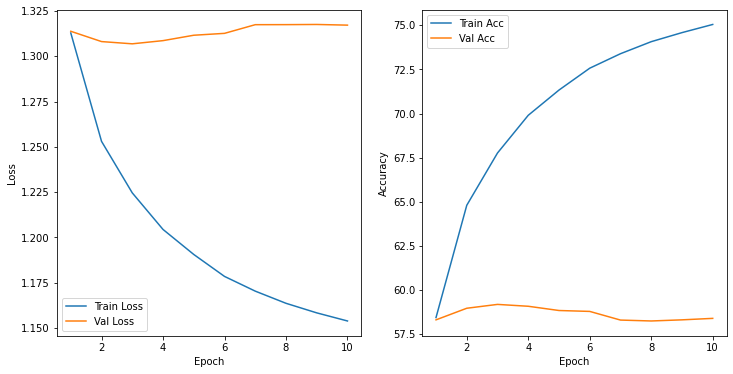

In [14]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(np.arange(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, num_epochs+1), train_accuracies, label='Train Acc')
plt.plot(np.arange(1, num_epochs+1), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 生成测试结果

In [ ]:
test = pd.read_csv('test.tsv', sep='\t')
test.sample(5)

In [ ]:
test['Sentiment'] = 0 # add fake label
X_test,y_test = extract_word_index_feat(test, idx2word, word2idx)

In [ ]:
test_dataset = SentimentDataset(X_test, y_test)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model.eval()
all_predicted = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predicted.append(predicted.numpy())
y_test = np.concatenate(all_predicted)

In [ ]:
test['Sentiment']=y_test
selected_columns = ['PhraseId', 'Sentiment']
test[selected_columns].to_csv('Sentiment_wordemb_MLP_gloveinit.csv', index=False)

In [ ]:
!ls